In [159]:
%load_ext autoreload
%autoreload 2

import datajoint as dj

dj.config["display.limit"] = 50
dj.config["enable_python_native_blobs"] = True
dj.config['schema_name'] = "nnfabrik_color_mei"
schema = dj.schema("nnfabrik_color_mei")

from matplotlib import pyplot as plt
from torch import load

from nnfabrik.main import *

import nnfabrik
from collections import namedtuple
from nnfabrik import main, builder
import os
from os import listdir
from os.path import isfile, join
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mlutils.measures import corr

from mlutils.data.datasets import StaticImageSet, FileTreeDataset
from nndichromacy.tables.from_nnfabrik import TrainedModel, DataInfo
from dataport.bcm.static import PreprocessedMouseData
from nnvision.utility.measures import get_explainable_var

from nndichromacy.tables.from_mei import MEI, TrainedEnsembleModel, MEISelector, MEIMethod, MEISeed

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
key = dict(dataset_hash='0f2b747f8547f639b1e112f3902873b9')

In [26]:
TrainedModel & key

model_fn name of the model function,model_hash hash of the model configuration,dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,seed Random seed that is passed to the model- and dataset-builder,comment short description,score loss,output trainer object's output,fabrikant_name Name of the contributor that added this entry,trainedmodel_ts UTZ timestamp at time of insertion
nndichromacy.models.se_core_full_gauss_readout,a09d55344b5793137349b8ca5d17d46d,nndichromacy.datasets.static_loaders,0f2b747f8547f639b1e112f3902873b9,nndichromacy.training.standart_trainer,0d06f037501e129d11aa288d8f22788f,1000,"standard_trainer.full_gauss_cortex.22564-3-12, grayscale, normalized",0.364164,=BLOB=,kwilleke,2020-06-06 12:24:01
nndichromacy.models.se_core_full_gauss_readout,a09d55344b5793137349b8ca5d17d46d,nndichromacy.datasets.static_loaders,0f2b747f8547f639b1e112f3902873b9,nndichromacy.training.standart_trainer,0d06f037501e129d11aa288d8f22788f,2000,"standard_trainer.full_gauss_cortex.22564-3-12, grayscale, normalized",0.363862,=BLOB=,kwilleke,2020-06-06 12:27:32
nndichromacy.models.se_core_full_gauss_readout,a09d55344b5793137349b8ca5d17d46d,nndichromacy.datasets.static_loaders,0f2b747f8547f639b1e112f3902873b9,nndichromacy.training.standart_trainer,0d06f037501e129d11aa288d8f22788f,3000,"standard_trainer.full_gauss_cortex.22564-3-12, grayscale, normalized",0.368424,=BLOB=,kwilleke,2020-06-06 12:31:35
nndichromacy.models.se_core_full_gauss_readout,a09d55344b5793137349b8ca5d17d46d,nndichromacy.datasets.static_loaders,0f2b747f8547f639b1e112f3902873b9,nndichromacy.training.standart_trainer,0d06f037501e129d11aa288d8f22788f,4000,"standard_trainer.full_gauss_cortex.22564-3-12, grayscale, normalized",0.366604,=BLOB=,kwilleke,2020-06-06 12:35:24
nndichromacy.models.se_core_full_gauss_readout,a09d55344b5793137349b8ca5d17d46d,nndichromacy.datasets.static_loaders,0f2b747f8547f639b1e112f3902873b9,nndichromacy.training.standart_trainer,0d06f037501e129d11aa288d8f22788f,5000,"standard_trainer.full_gauss_cortex.22564-3-12, grayscale, normalized",0.359381,=BLOB=,kwilleke,2020-06-06 12:39:27


In [16]:
from nndichromacy.tables.legacy.from_mei import LegacyMEI, LegacyMEIMethod, LegacyMouseSelector, LegacyTrainedEnsembleModel

In [18]:
LegacyMouseSelector().populate(key, display_progress=True)

  0%|          | 0/1 [00:00<?, ?it/s]

static22564-3-12-preproc0 exists already. Not unpacking static22564-3-12-preproc0.zip


100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


In [28]:
LegacyTrainedEnsembleModel()

dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,ensemble_hash the hash of the ensemble
nndichromacy.datasets.static_loaders,0f2b747f8547f639b1e112f3902873b9,bd6e413e035619910b66d83e19127c3d


In [78]:
contrasts = [0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35]

In [171]:
for num_iter in [50, 200]:
    for contrast in contrasts:
        
        contrast_function = 'nndichromacy.legacy.mei_helpers.regularizers.postup_contrast_' + str(contrast).replace('.', '')
        method_fn = 'nndichromacy.legacy.featurevis.methods.gradient_ascent',
        method_config = {'transform': None,
           'regularization': None,
           'gradient_f': 'nndichromacy.legacy.mei_helpers.regularizers.Blur_sigma_1',
           'post_update': contrast_function,
           'optim_name': 'SGD',
           'step_size': contrast * 10,
           'optim_kwargs': None,
           'num_iterations': num_iter}


        LegacyMEIMethod().add_method(method_fn, method_config)

In [173]:
keys_to_pop = ((MEI&key) & dict(method_hash='02610862f7ab76a88b94566b6aa98111')).fetch("unit_id", "data_key", as_dict=True)

In [175]:

for this_key in keys_to_pop:
    this_key["neuron_id"] = this_key["unit_id"]
    this_key["session_id"] = this_key["data_key"]
    this_key["dataset_hash"] = '0f2b747f8547f639b1e112f3902873b9'

In [ ]:
LegacyMEI().populate(keys_to_pop, display_progress=True)

In [180]:

MEIs, MEIs_score = {}, {}
lr, std, scores, var_score, n_iter = [], [], [], [], []

for keys in LegacyMEIMethod:
    keys["dataset_hash"] = '0f2b747f8547f639b1e112f3902873b9'

    if len(LegacyMEI&keys)>0:
        lr_i = keys["method_config"]["step_size"]
        lr.append(lr_i)

        std.append(lr_i/10)
        
        n_iter_i = keys["method_config"]["num_iterations"]
        n_iter.append(n_iter_i)
        
        MEIs[f"{lr_i}_{lr_i/10}_{n_iter_i}"] = [torch.load(path).detach().cpu().numpy().squeeze() for path in (LegacyMEI&keys).fetch("mei", order_by="neuron_id")]


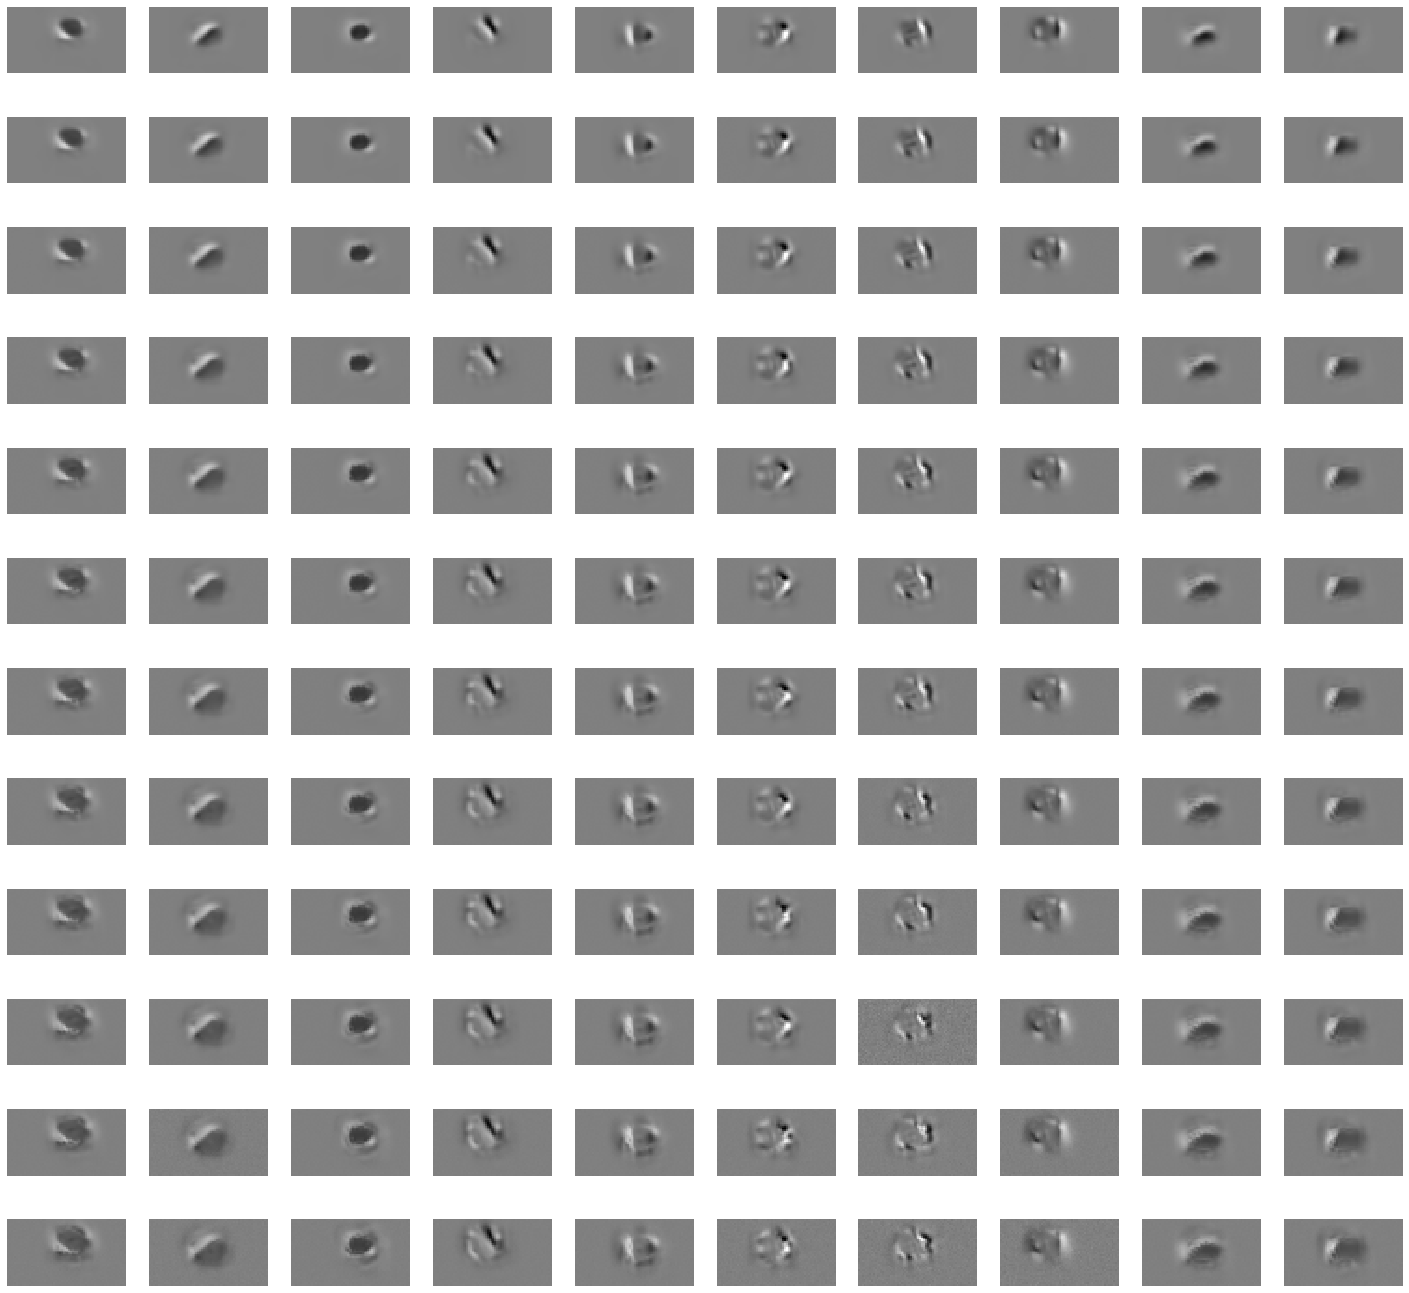

In [252]:

fig, axs = plt.subplots(n_rows,10, figsize=(25, n_rows*2))
for i, ax in enumerate(axs.ravel()):
    
    mei = MEI_subset[i]
    mei = mei * (0.1 / mei.std())
    vmax = np.max(np.abs(mei))
    ax.imshow(mei, cmap="gray", vmax=1, vmin=-1)
    #ax.set_title(f"std = {mei_std[i//10]} \n activation = {np.round(Score_subset[i],1)}'")

    ax.axis("off")

plt.savefig("MEI_previous_pipeline_version_MEIs.png", dpi=75, bbox_inches="tight")

# Reproducing MEIs with original featurevis code

In [ ]:
import torch
import matplotlib.pyplot as plt


import nndichromacy.legacy.featurevis

from nndichromacy.legacy.featurevis import models
from nndichromacy.legacy.featurevis import ops
from nndichromacy.legacy.featurevis import utils

from nndichromacy.legacy.featurevis.integration import import_module
from nndichromacy.legacy.mei_helpers.regularizers import Blur_sigma_1
from nndichromacy.legacy.mei_helpers.regularizers import postup_contrast_01, postup_contrast_03, postup_contrast_02

In [187]:
# get a list of 5 models used in original ensemble
model_list = []
for restr in (TrainedModel & key).proj():
    _, model = (TrainedModel & restr).load_model()
    model_list.append(model)


static22564-3-12-preproc0 exists already. Not unpacking static22564-3-12-preproc0.zip
static22564-3-12-preproc0 exists already. Not unpacking static22564-3-12-preproc0.zip
static22564-3-12-preproc0 exists already. Not unpacking static22564-3-12-preproc0.zip
static22564-3-12-preproc0 exists already. Not unpacking static22564-3-12-preproc0.zip
static22564-3-12-preproc0 exists already. Not unpacking static22564-3-12-preproc0.zip


In [183]:
LegacyMouseSelector & keys_to_pop

dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,neuron_id unique neuron identifier,neuron_position integer position of the neuron in the model's output,session_id unique session identifier
nndichromacy.datasets.static_loaders,0f2b747f8547f639b1e112f3902873b9,983,883,22564-3-12-0
nndichromacy.datasets.static_loaders,0f2b747f8547f639b1e112f3902873b9,1590,1443,22564-3-12-0
nndichromacy.datasets.static_loaders,0f2b747f8547f639b1e112f3902873b9,2731,2462,22564-3-12-0
nndichromacy.datasets.static_loaders,0f2b747f8547f639b1e112f3902873b9,2992,2705,22564-3-12-0
nndichromacy.datasets.static_loaders,0f2b747f8547f639b1e112f3902873b9,3767,3414,22564-3-12-0
nndichromacy.datasets.static_loaders,0f2b747f8547f639b1e112f3902873b9,3873,3512,22564-3-12-0
nndichromacy.datasets.static_loaders,0f2b747f8547f639b1e112f3902873b9,4801,4392,22564-3-12-0
nndichromacy.datasets.static_loaders,0f2b747f8547f639b1e112f3902873b9,6090,5591,22564-3-12-0
nndichromacy.datasets.static_loaders,0f2b747f8547f639b1e112f3902873b9,6795,6230,22564-3-12-0
nndichromacy.datasets.static_loaders,0f2b747f8547f639b1e112f3902873b9,7052,6473,22564-3-12-0


In [240]:
model = models.Ensemble(models=model_list, readout_key='22564-3-12-0', neuron_idx=1443, device='cuda')

In [241]:
initial_image = torch.randn(1, 1, 36, 64, dtype=torch.float32, device="cuda")  # grayscale random image

# Generating a Single MEI

In [226]:
opt_x, fevals, reg_values =  nndichromacy.legacy.featurevis.gradient_ascent(model, initial_image, step_size=1, num_iterations=500, 
                                                       post_update=postup_contrast_01, gradient_f=Blur_sigma_1)

Iter 100: f(x) = 5.33, reg(x) = 0.00, std(x) = 0.10
Iter 200: f(x) = 5.33, reg(x) = 0.00, std(x) = 0.10
Iter 300: f(x) = 5.33, reg(x) = 0.00, std(x) = 0.10
Iter 400: f(x) = 5.33, reg(x) = 0.00, std(x) = 0.10
Iter 500: f(x) = 5.33, reg(x) = 0.00, std(x) = 0.10
Final f(x) = 5.33


In [227]:
mei = opt_x.detach().cpu().numpy().squeeze()
mei = mei * (0.1 / mei.std())

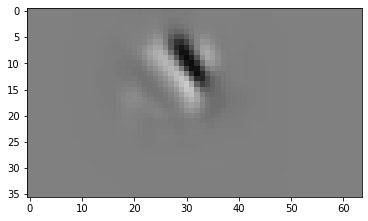

In [228]:
plt.imshow(mei, cmap="gray", vmin=-1, vmax=1)

# Generate MEIs for all contrasts

In [ ]:
for contrast in contrasts:

    contrast_function = 'nndichromacy.legacy.mei_helpers.regularizers.postup_contrast_' + str(contrast).replace('.', '')
    post_update = import_module(contrast_function)
    
    opt_x, fevals, reg_values =  nndichromacy.legacy.featurevis.gradient_ascent(model, initial_image, step_size=contrast*10, num_iterations=500, 
                                                       post_update=post_update, gradient_f=Blur_sigma_1)
    mei = opt_x.detach().cpu().numpy().squeeze()
    mei = mei * (0.1 / mei.std())
    legacy_MEIs.append(mei)

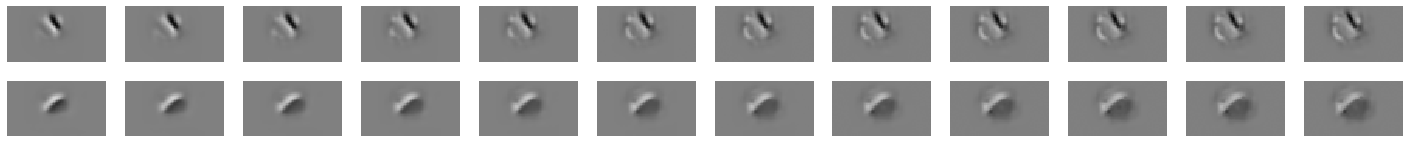

In [250]:
# show MEIs for 
fig, axs = plt.subplots(2, 12, figsize=(25, 2.5))
for i, ax in enumerate(axs.ravel()):
    
    ax.imshow(legacy_MEIs[i], cmap="gray", vmax=1, vmin=-1)
    ax.axis("off")
    
plt.savefig("cajal_featurevis_nnkonsti.png", dpi=100, bbox_inches="tight")